# Implementación demodulador BFSK no coherente

In [2]:
import matplotlib.pyplot as plt
import numpy as np

Generamos un array con los coeficientes de un periodo de cada una de las dos señales senoidales a frecuencias distintas y con una frecuencia de muestreo determinada. Usamos senoidales de amplitud unidad.

In [3]:
fs = 44100 # Frecuencia de muestreo estándar
frec0 = 2756.25 # Frecuencia de la senoidal para el cero
frec1 = 5512.5 # Frecuencia de la senoidal para el uno

# Obtenemos los instantes en los que se debe evaluar el seno a cada frecuencia
t0 = np.arange(0, 1/frec0, 1/fs)
t1 = np.arange(0, 1/frec1, 1/fs)

signal0 = np.sin(2*np.pi*frec0*t0)
signal1 = np.sin(2*np.pi*frec1*t1)

Se representan las muestras almacenadas de las señales.

<StemContainer object of 3 artists>

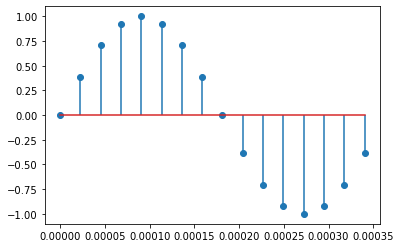

In [4]:
plt.stem(t0,signal0,use_line_collection=True)

<StemContainer object of 3 artists>

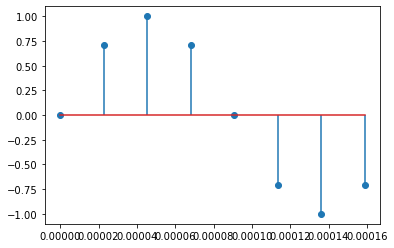

In [5]:
plt.stem(t1,signal1,use_line_collection=True)

Utilizamos una señal de prueba a la entrada del demodulador, compuesta por la concatenación de varios periodos de cada una de las señales.

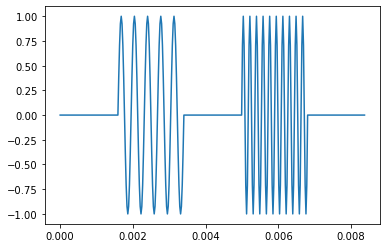

In [6]:
inputSignal = np.concatenate((np.zeros(70),np.tile(signal0,5),np.zeros(70),np.tile(signal1,10),np.zeros(70)))
inputTime = np.arange(0, np.size(inputSignal)/fs, 1/fs)

plt.plot(inputTime,inputSignal)

Diseñamos un filtro FIR con frecuencia central frec0 y otro con frecuencia central frec1. El ancho de banda de los filtros es de 3 kHz, y la caída configurada en el software de diseño de filtros es también de 2 kHz. Usamos a priori una ventana rectangular porque es la que necesita menos coeficientes y el filtro será más rápido. Es muy importante que los filtros tengan el mismo número de coeficientes para que la velocidad sea la misma.

In [7]:
# Coeficientes del filtro con frecuencia central f0 y ancho de banda 3 kHz
h0 = [
    0.000241873203082902,
    0.001183922730392509,
    0.002718342940178557,
    0.004475534626417673,
    0.005872796407843636,
    0.006229020396342074,
    0.004919338093220696,
    0.001530684615480861,
    -0.004023069608989851,
    -0.011458389648644221,
    -0.027836637825669606,
    -0.058150631010158327,
    -0.081782997553550438,
    -0.090717753087522529,
    -0.079752792737455086,
    -0.048239239310933407,
    -0.000681941759490187,
    0.054036398080732156,
    0.104657351978799190,
    0.140268481094392050,
    0.153019416751064757,
    0.140268481094390857,
    0.104657351978799384,
    0.054036398080732725,
    -0.000681941759490269,
    -0.048239239310933525,
    -0.079752792737455128,
    -0.090717753087522834,
    -0.081782997553550521,
    -0.058150631010158216,
    -0.027836637825669586,
    -0.011458389648644193,
    -0.004023069608989868,
    0.001530684615480841,
    0.004919338093220694,
    0.006229020396342039,
    0.005872796407843596,
    0.004475534626417648,
    0.002718342940178530,
    0.001183922730392482,
    0.000241873203082890,
]

# Coeficientes del filtro con frecuencia central f1 y ancho de banda 3 kHz
h1 = [
    -0.000311341691536864,
    -0.000314904795981969,
    0.000508327471209296,
    0.001886713825960092,
    0.002669278280304561,
    0.001628902830305445,
    -0.001285223879872147,
    -0.004212533294060983,
    -0.003964774370143719,
    0.002107278500657695,
    -0.002546211988778624,
    0.042125896162662754,
    0.075005720377210539,
    0.063022777008648945,
    0.001168622691895529,
    -0.077692228319504716,
    -0.121860302795318634,
    -0.097149587276850802,
    -0.014025157134872221,
    0.076045894155919502,
    0.114385708484295051,
    0.076045894155918003,
    -0.014025157134872086,
    -0.097149587276850830,
    -0.121860302795318842,
    -0.077692228319504508,
    0.001168622691895493,
    0.063022777008649125,
    0.075005720377210594,
    0.042125896162662685,
    -0.002546211988778749,
    0.002107278500657580,
    -0.003964774370143733,
    -0.004212533294060954,
    -0.001285223879872102,
    0.001628902830305454,
    0.002669278280304540,
    0.001886713825960082,
    0.000508327471209288,
    -0.000314904795981985,
    -0.000311341691536884,
]

Creamos una clase para un filtro FIR que tendrá los métodos apropiados para manejar una lista circular (buffer circular). Para la implementación en C será necesaria una función init que inicialize las variables del filtro.

In [8]:
class FIR_Filter:
    def __init__(self, coefs):
        self.h = coefs # Coeficientes del filtro
        
        # Atributos asociados al buffer circular
        self.buf = [0]*len(self.h)
        self.bufIndex = 0 
        
        # Salida actual del filtro
        self.out = 0
    
    def FIRFilterClear(self):
        self.buf = [0]*len(self.h)
        self.bufIndex = 0
        self.out = 0
    
    def FIRFilterUpdate(self, filterInput):
        
        # Metemos la última muestra en el buffer circular
        self.buf[self.bufIndex] = filterInput
        
        # Incrementamos el índice
        self.bufIndex += 1
        
        if self.bufIndex == len(self.buf):
            self.bufIndex = 0
        
        # Computamos el nuevo valor de la salida
        self.out = 0
        
        sumIndex = self.bufIndex
        
        for n in range(len(self.buf)):
            if sumIndex > 0:
                sumIndex -= 1
            else:
                sumIndex = len(self.buf)-1
                
            self.out += self.h[n]*self.buf[sumIndex]

Creamos un objeto por cada filtro e introducimos la señal de prueba, representando la salida de cada filtro y la señal original.

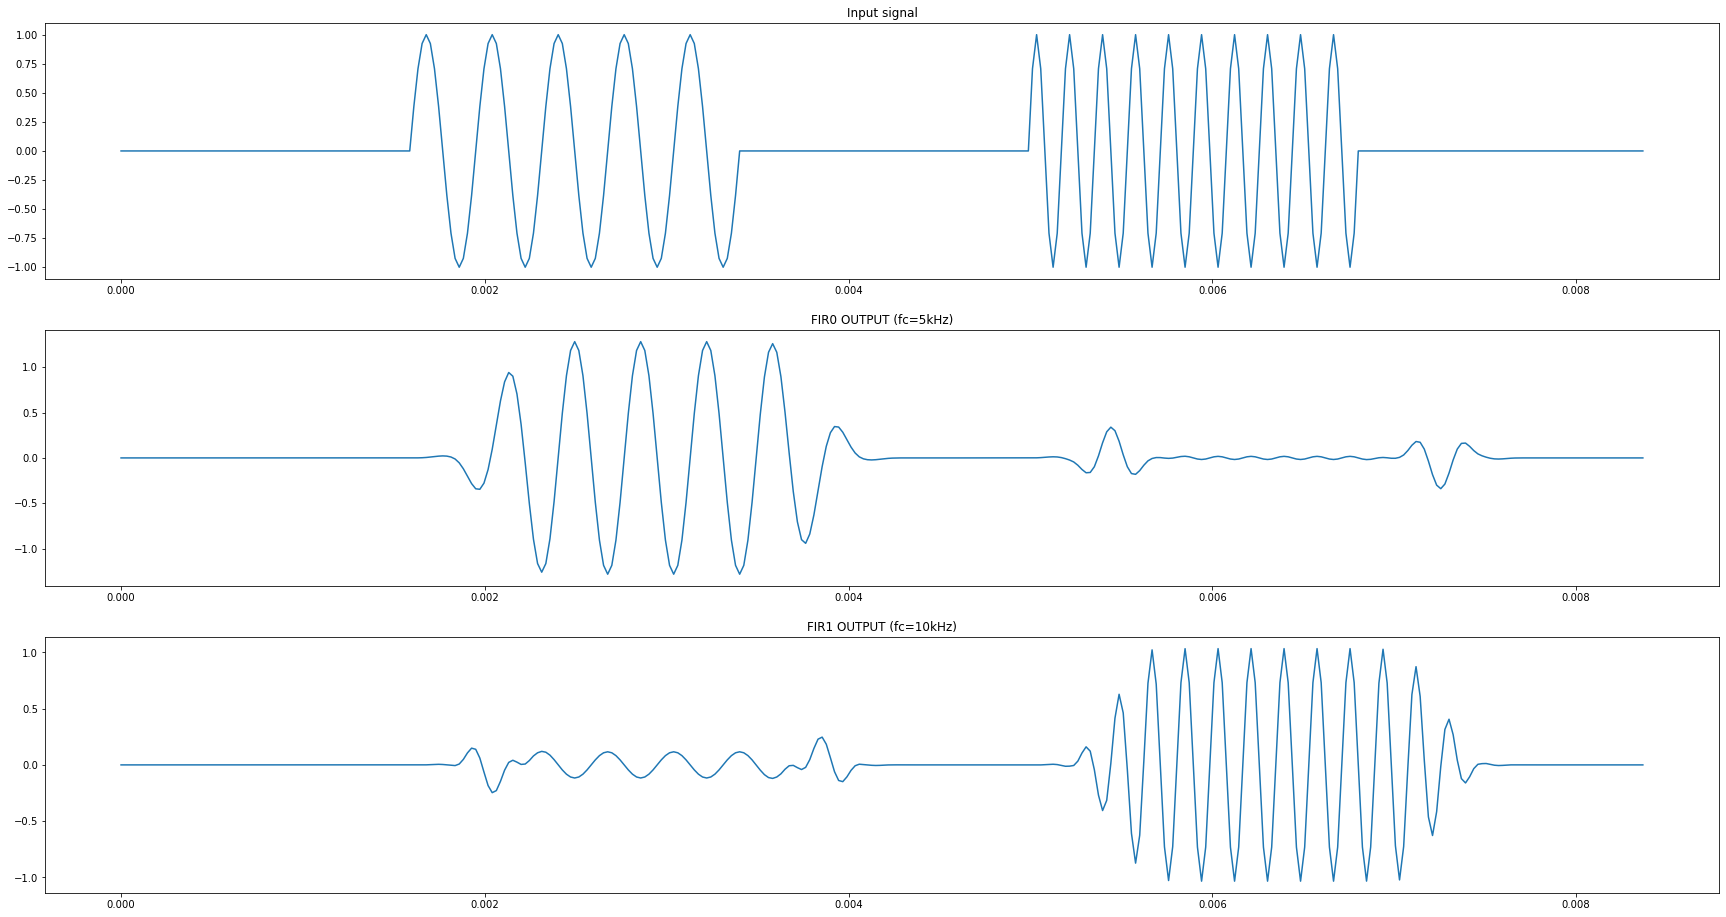

In [9]:
fir0 = FIR_Filter(h0)
fir1 = FIR_Filter(h1)

salida_fir0 = np.array([])
salida_fir1 = np.array([])

for sample in inputSignal:
    # Actualizamos el valor de los dos filtros
    fir0.FIRFilterUpdate(sample)
    fir1.FIRFilterUpdate(sample)
    
    salida_fir0 = np.append(salida_fir0,fir0.out)
    salida_fir1 = np.append(salida_fir1,fir1.out)

fig, axes = plt.subplots(3,1,figsize=(30,16))
axes[0].set_title("Input signal")
axes[0].plot(inputTime,inputSignal)
axes[1].set_title("FIR0 OUTPUT (fc=5kHz)")
axes[1].plot(inputTime,salida_fir0)
axes[2].set_title("FIR1 OUTPUT (fc=10kHz)")
axes[2].plot(inputTime,salida_fir1)

Ahora probamos con un paquete de capa física formado por un bit de stop, un bit de start, 8 bits de datos y un bit de paridad par.

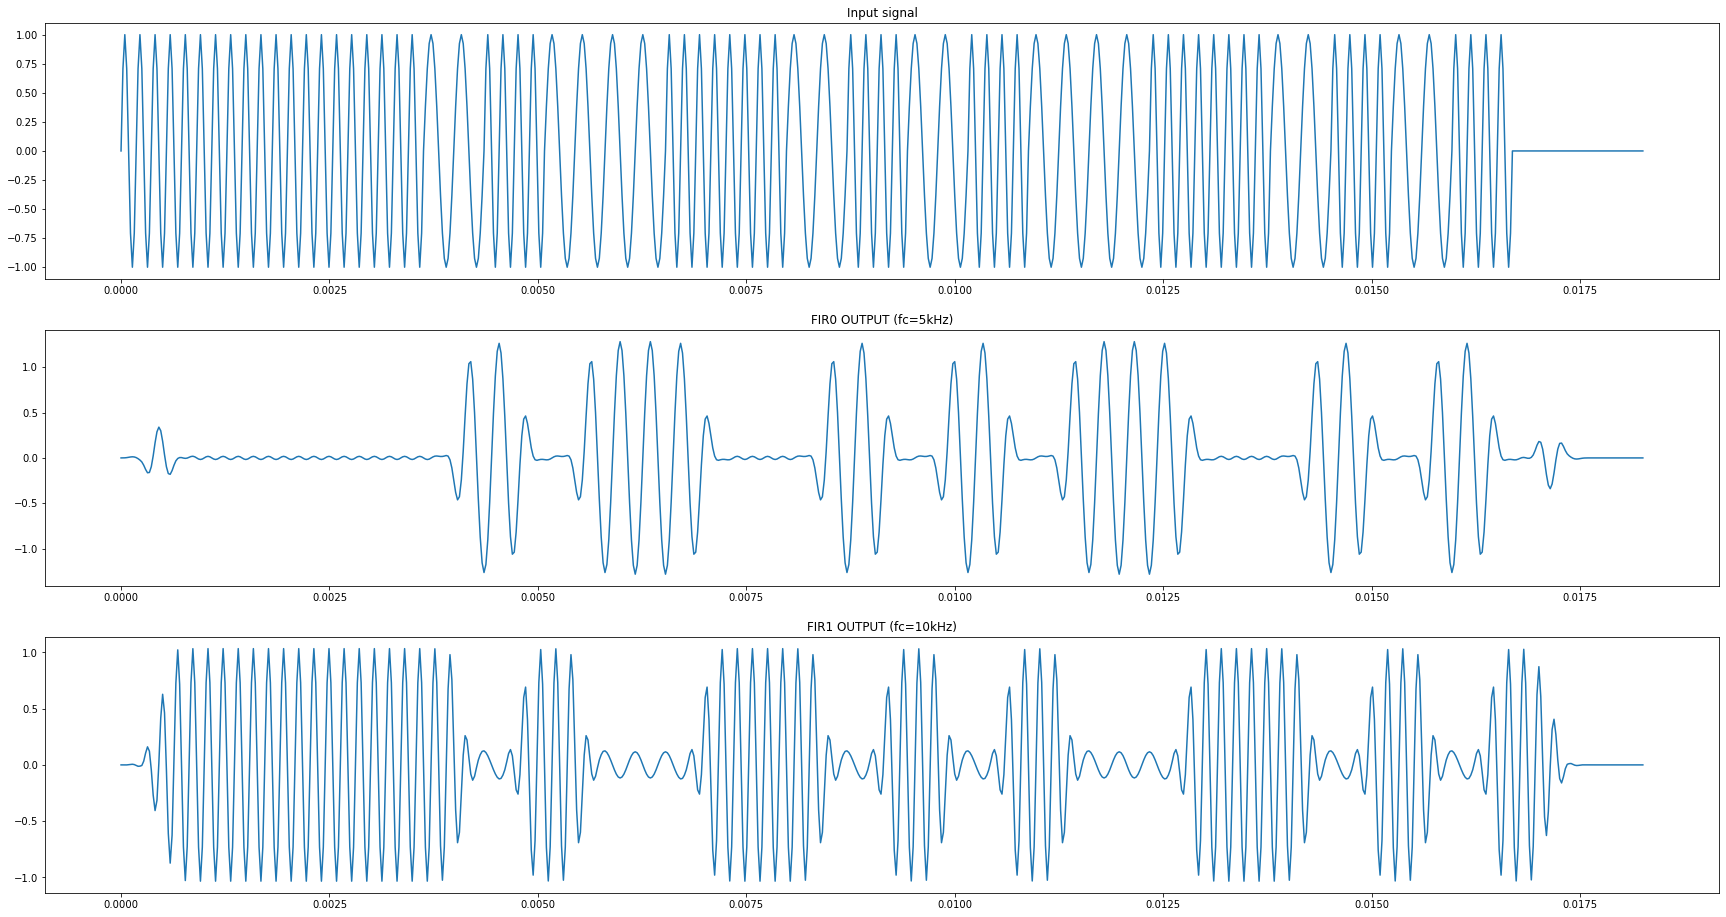

In [18]:
inputSignal = np.concatenate((np.tile(signal1,16),
                              np.tile(signal1,4), # BIT STOP
                              np.tile(signal0,2), # BIT START
                              np.tile(signal1,4), # COMIENZO DATOS
                              np.tile(signal0,2),
                              np.tile(signal0,2),
                              np.tile(signal1,4),
                              np.tile(signal1,4),
                              np.tile(signal0,2),
                              np.tile(signal1,4),
                              np.tile(signal0,2),
                              np.tile(signal1,4),
                              np.tile(signal0,2),
                              np.tile(signal0,2),
                              np.tile(signal1,4),
                              np.tile(signal1,4),
                              np.tile(signal0,2),
                              np.tile(signal1,4),
                              np.tile(signal0,2),
                              np.tile(signal1,4), # BIT PARIDAD (PAR),
                              np.zeros(70)
                             ))
inputTime = np.arange(0, np.size(inputSignal)/fs, 1/fs)

# Reiniciamos los filtros
fir0.FIRFilterClear()
fir1.FIRFilterClear()

salida_fir0 = np.array([])
salida_fir1 = np.array([])

for sample in inputSignal:
    # Actualizamos el valor de los dos filtros
    fir0.FIRFilterUpdate(sample)
    fir1.FIRFilterUpdate(sample)
    
    salida_fir0 = np.append(salida_fir0,fir0.out)
    salida_fir1 = np.append(salida_fir1,fir1.out)

fig, axes = plt.subplots(3,1,figsize=(30,16))
axes[0].set_title("Input signal")
axes[0].plot(inputTime,inputSignal)
axes[1].set_title("FIR0 OUTPUT (fc=5kHz)")
axes[1].plot(inputTime,salida_fir0)
axes[2].set_title("FIR1 OUTPUT (fc=10kHz)")
axes[2].plot(inputTime,salida_fir1)

Lo siguiente es llevar a cabo la implementación de un detector de envolvente, que irá tras cada una de las salidas filtradas. El detector de envolvente estará compuesto por un bloque que efectúa el valor absoluto y otro bloque que le hace un filtrado paso de baja. A la salida tendríamos una señal proporcional a su envolvente.

In [19]:
class EnvelopeDetector:
    def __init__(self,coef):
        
        self.LP_fir_filter = FIR_Filter(coef)
        
        self.out = 0
    
    def clear(self):
        self.LP_fir_filter.FIRFilterClear()
        
        self.out = 0
    
    def update(self,envelopeInput):
        
        # Tomamos valor absoluto a la muestra recibida
        sample = np.abs(envelopeInput)
        
        self.LP_fir_filter.FIRFilterUpdate(sample)
        
        self.out = self.LP_fir_filter.out

Se diseña un filtro paso de baja para usarlo en el detector de envolvente. El filtro paso de baja diseñado tiene un ancho de banda de 500 hz y una caída de 2kHz. Se utiliza ventana rectangular por su simplicidad.

In [20]:
# Coeficientes del filtro paso de baja del detector de envolvente
h_env = [
    0.045066907137521421,
    0.045820575643761983,
    0.046501173159741213,
    0.047106642713001412,
    0.047635151455958924,
    0.048085097286934234,
    0.048455114642117027,
    0.048744079435647437,
    0.048951113128342105,
    0.049075585909023091,
    0.049117118975902395,
    0.049075585909023091,
    0.048951113128342105,
    0.048744079435647437,
    0.048455114642117027,
    0.048085097286934234,
    0.047635151455958924,
    0.047106642713001412,
    0.046501173159741213,
    0.045820575643761983,
    0.045066907137521421,
]

Instanciamos ahora dos detectores de envolventes y representamos la salida de los mismos introduciendo como entrada las salidas de los filtros FIR paso de banda.

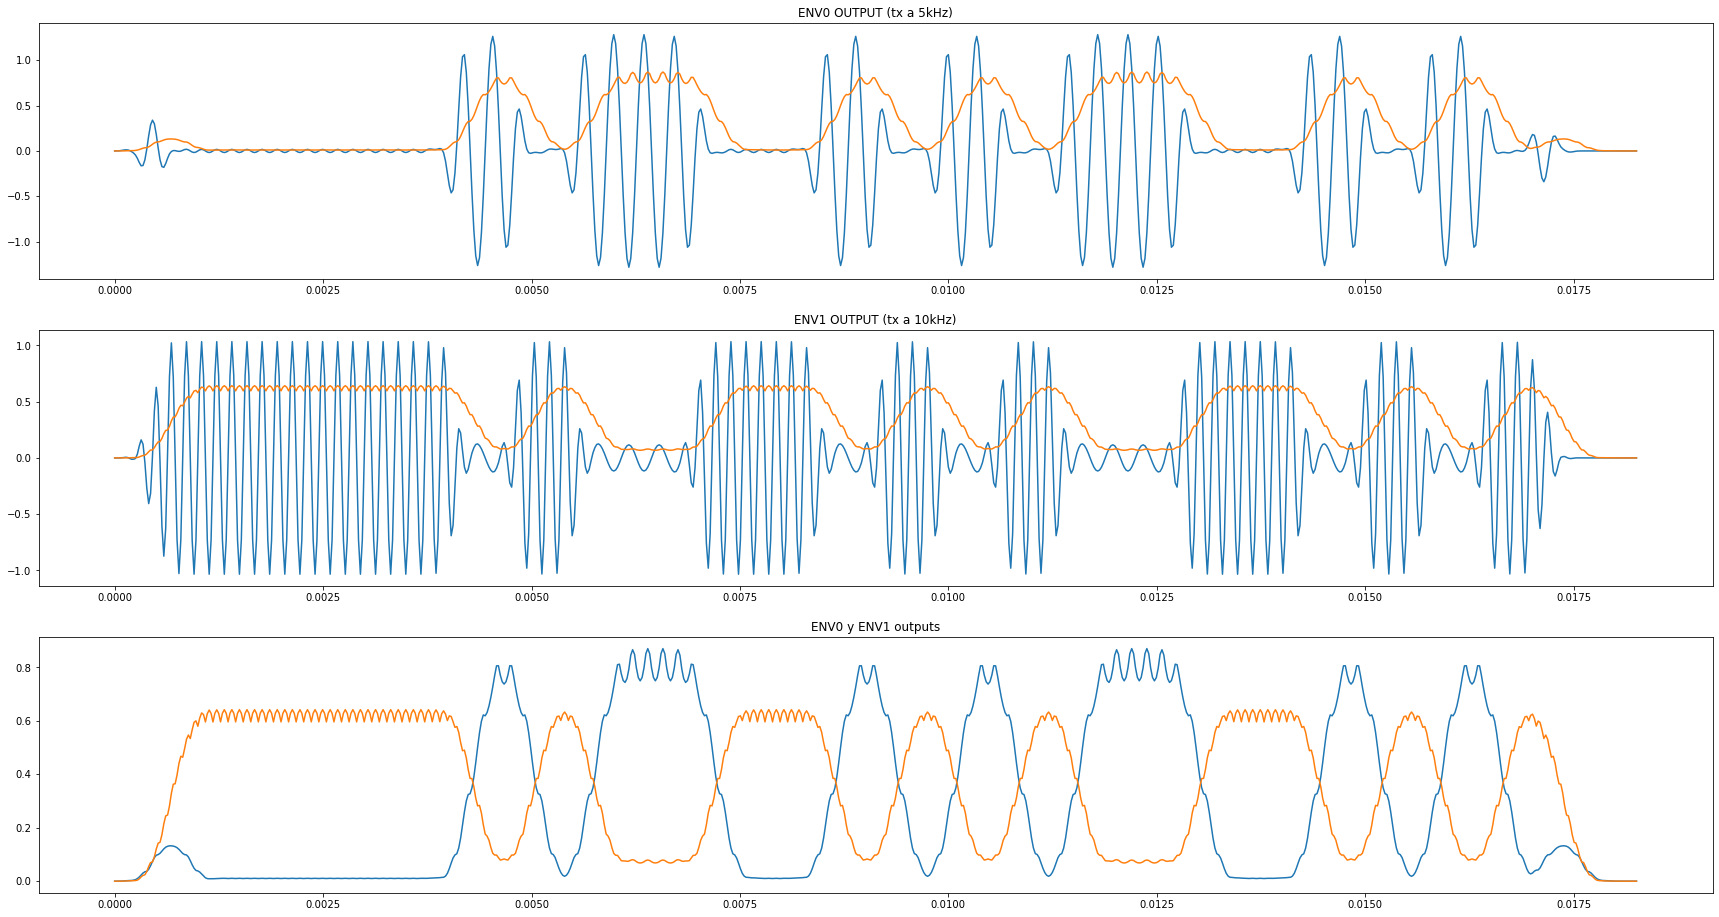

In [21]:
env0 = EnvelopeDetector(h_env)
env1 = EnvelopeDetector(h_env)

salida_env0 = np.array([])
salida_env1 = np.array([])

for sampleIndex in range(np.size(inputSignal)):
    # Actualizamos el valor de los dos filtros
    env0.update(salida_fir0[sampleIndex])
    env1.update(salida_fir1[sampleIndex])
    
    salida_env0 = np.append(salida_env0,env0.out)
    salida_env1 = np.append(salida_env1,env1.out)
    
fig, axes = plt.subplots(3,1,figsize=(30,16))
axes[0].set_title("ENV0 OUTPUT (tx a 5kHz)")
axes[0].plot(inputTime,salida_fir0,inputTime,salida_env0)
axes[1].set_title("ENV1 OUTPUT (tx a 10kHz)")
axes[1].plot(inputTime,salida_fir1,inputTime,salida_env1)
axes[2].set_title("ENV0 y ENV1 outputs")
axes[2].plot(inputTime,salida_env0,inputTime,salida_env1)